Setting Library

In [20]:
#Data Prrocessing
import pandas as pd
import datetime as dt
import numpy as np

#API
import vnstock
from vnstock import *

#Visualization
import matplotlib.pyplot as plt

#Predictions
import tensorflow as tf
tf.config.list_physical_devices('GPU') #GPU device
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras import optimizers

Load data

In [21]:
#Company list
companies = []
fhandle = open("Data\companylist.txt","r")
order = 0
for line in fhandle.readlines():
    company = line.strip()
    order += 1
    print(f"{order}.{company}'s stock")

1.FPT's stock
2.CTG's stock
3.LCG's stock


In [22]:
company = 'FPT'
df = pd.read_csv(f"Data\Raw\{company}.csv", delimiter = ",", encoding="utf-8")
df

,Unnamed: 0,Open,High,Low,Close,Volume,TradingDate
0,0,15710.0,15710.0,15710.0,15710.0,83530,2006-12-13
1,1,16495.0,16495.0,16495.0,16495.0,280710,2006-12-14
2,2,17320.0,17320.0,17320.0,17320.0,265300,2006-12-15
3,3,18184.0,18184.0,18184.0,18184.0,215790,2006-12-18
4,4,19087.0,19087.0,19087.0,19087.0,137520,2006-12-19
...,...,...,...,...,...,...,...
4016,4016,84200.0,84400.0,83700.0,83700.0,893299,2023-01-30
4017,4017,83500.0,83700.0,81700.0,83500.0,1531495,2023-01-31
4018,4018,84000.0,84000.0,81800.0,82000.0,1051061,2023-02-01
4019,4019,82100.0,82400.0,81300.0,81900.0,1327690,2023-02-02


Preprocessing data

In [23]:
#Format data
df['TradingDate'] = pd.to_datetime(df.TradingDate, format = "%Y/%m/%d")

In [24]:
#Candlesticks
df['H-L'] = df['High'] - df['Low']
df['O-C'] = df['Open'] - df['Close']

#Simple moving average
MA1 = 7
MA2 = 14
MA3 = 21
df[f'SMA_{MA1}'] = df['Close'].rolling(window = MA1).mean()
df[f'SMA_{MA2}'] = df['Close'].rolling(window = MA2).mean()
df[f'SMA_{MA3}'] = df['Close'].rolling(window = MA3).mean()

#Standard deviation
df[f'SD_{MA1}'] = df['Close'].rolling(window = MA1).std()
df[f'SD_{MA3}'] = df['Close'].rolling(window = MA3).std()

#Drop missing data
df.dropna(inplace = True)

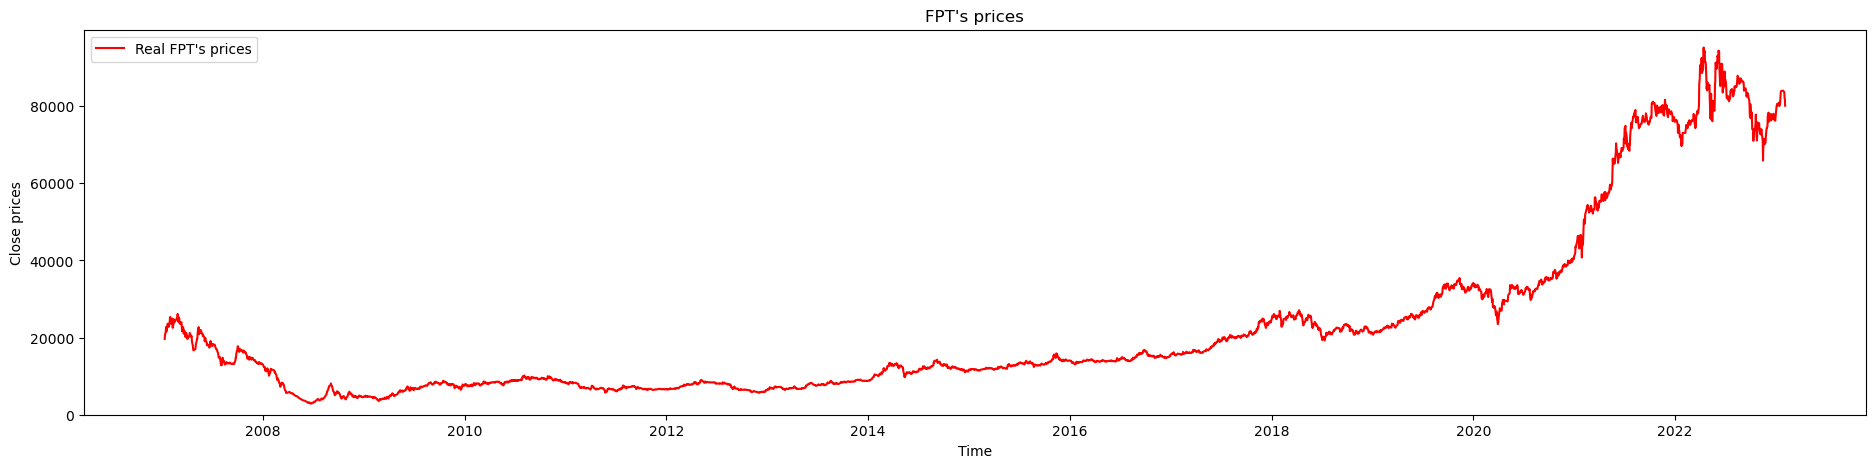

In [25]:
#Visualization
real_price = pd.DataFrame(df, columns = ['TradingDate', 'Close'])
real_price.index = real_price.TradingDate
real_price.drop('TradingDate', axis = 1, inplace = True)
plt.figure(figsize = (23,5))
plt.plot(real_price['Close'], color = "red", label = f"Real {company}'s prices")
plt.title(f"{company}'s prices")
plt.xlabel("Time")
plt.ylabel("Close prices")
plt.ylim(bottom = 0)
plt.legend() #Notices
plt.show()

In [26]:
#Exporting data
df.to_csv(f"Data\Prepaired\{company}pre.csv", encoding = "utf-8")

Processing Data

In [27]:
#Set domain
scaler_x = MinMaxScaler(feature_range = (0, 1))
scaler_y = MinMaxScaler(feature_range = (0, 1))

In [28]:
#Fit data
cols_x = ['H-L', 'O-C', f'SMA_{MA1}', f'SMA_{MA2}', f'SMA_{MA3}', f'SD_{MA1}', f'SD_{MA3}'] #Variables for training
cols_y = ['Close'] #Variable for predict
scaled_data_x = scaler_x.fit_transform(df[cols_x].values.reshape(-1, len(cols_x))) 
scaled_data_y = scaler_y.fit_transform(df[cols_y].values.reshape(-1, len(cols_y)))

In [29]:
df.head()

,Unnamed: 0,Open,High,Low,Close,Volume,TradingDate,H-L,O-C,SMA_7,SMA_14,SMA_21,SD_7,SD_21
20,20,19637.0,19637.0,19637.0,19637.0,283920,2007-01-11,0.0,0.0,19031.571429,18543.357143,18356.238095,692.763032,1111.115021
21,21,20619.0,20619.0,20619.0,20619.0,279710,2007-01-12,0.0,0.0,19452.285714,18722.857143,18590.000000,621.483364,1040.709133
22,22,21012.0,21640.0,21012.0,21640.0,274290,2007-01-15,628.0,-628.0,19895.428571,19039.857143,18835.000000,903.049991,1125.043555
23,23,22701.0,22701.0,22701.0,22701.0,339760,2007-01-16,0.0,0.0,20361.142857,19373.714286,19091.238095,1356.434840,1352.523083
24,24,23526.0,23526.0,21601.0,21601.0,145870,2007-01-17,1925.0,1925.0,20697.714286,19570.071429,19253.952381,1325.267358,1440.593679


In [30]:
#Training seq X and output value Y
pre_day = 30
x_total = [] # Variables today
y_total = [] #Close price tomorrow
for i in range(pre_day, len(df)):
    x_total.append(scaled_data_x[i-pre_day:i])
    y_total.append(scaled_data_y[i])

In [31]:
#Set test
test_size = 365

#Traning set
x_train = np.array(x_total[:len(x_total)-test_size]) #tranning set (0, 30)
y_train = np.array(y_total[:len(y_total)-test_size]) #taget tranning set

#Predicted set
x_test = np.array(x_total[len(x_total)-test_size:]) #predicted set (31,...)
y_test = np.array(y_total[len(y_total)-test_size:]) #taget predicted set

#Structure of tranning data
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(3941, 30, 7) (3941, 1) (30, 30, 7) (30, 1)


Build Model

In [32]:
#Layers
model = Sequential()
cells = 40
model.add(LSTM(units = cells, return_sequences = True, input_shape = (x_train.shape[1], x_train.shape[2]))) #input traning date and predicting date 
model.add(Dropout(0.1))
model.add(LSTM(units = cells, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = cells, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = cells, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = cells))
model.add(Dropout(0.2))
model.add(Dense(units = len(cols_y))) 

In [33]:
#Optimizer
model.compile(optimizer = optimizers.RMSprop(), loss = 'mse', metrics = ['accuracy']) #Optimizer, loss
history = model.fit(x_train, y_train, epochs = 1, batch_size = 1, use_multiprocessing = True)#Fit input to taget
len(history.history['loss'])

In [ ]:
#Save model
from keras.models import save_model

save_model(model, f"Model\{company}.h5", include_optimizer = True)

Testing

In [ ]:
#Load model
from keras.models import load_model

model = load_model(f"Model\{company}.h5")

1/1 [==============================] - 0s 30ms/step


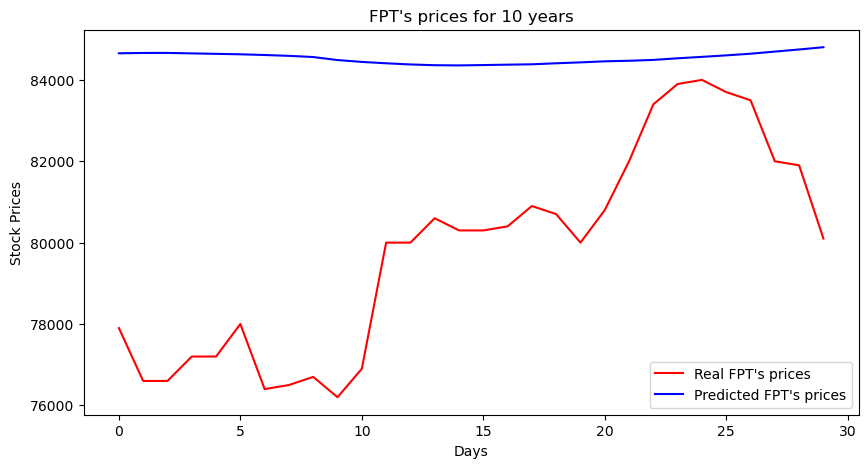

In [ ]:
#Visualization
real_price = df[len(df)-test_size:]['Close'].values.reshape(-1, 1)
real_price = np.array(real_price)
real_price = real_price.reshape(real_price.shape[0], 1)
predict_prices = model.predict(x_test)
predict_prices = scaler_y.inverse_transform(predict_prices)

plt.figure(figsize = (10,5))
plt.plot(real_price, color = "red", label = f"Real {company}'s prices")
plt.plot(predict_prices, color = "blue", label = f"Predicted {company}'s prices")
plt.title(f"{company}'s prices for 10 years")
plt.xlabel("Days")
plt.ylabel("Stock Prices")
plt.legend()
plt.show()